In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '15'

In [8]:
from platform import python_version
import tensorflow as tf
import tensorflow_io as tfio
print('Python Version        : ', python_version())
print('TensorFlow Version    : ', tf.__version__)
print('TensorFlow-IO Version    : ', tfio.__version__)

Python Version        :  3.11.8
TensorFlow Version    :  2.15.1
TensorFlow-IO Version    :  0.35.0


In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import shutil
import os
import numpy as np
import soundfile as sf
import scipy.signal

In [10]:
base_dir = 'Train'
base_dir_test = 'Test'

In [11]:
def load_wav_16k_mono(path):
    file_contents = tf.io.read_file(path)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [12]:
sample_test = os.path.join('Train', '0_7.wav')
wave = load_wav_16k_mono(sample_test)
test_wave_label = sample_test.split(os.sep)[-1].split('_')[0]

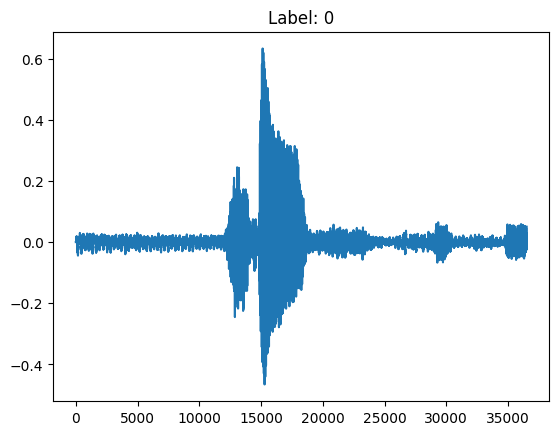

In [13]:
plt.title('Label: ' + test_wave_label)
plt.plot(wave)
plt.show()

## Create Tensorflow Datasets

In [14]:
data_path = tf.data.Dataset.list_files(base_dir + '/*.wav')
def extract_class(file_path):
    file_name = tf.strings.split(file_path, '/')[-1]
    class_name = tf.strings.split(file_name, '_')[0]
    return file_path, int(class_name)
dataset = data_path.map(lambda x: extract_class(x))

In [15]:
data_path_test = tf.data.Dataset.list_files(base_dir_test + '/*.wav')

In [16]:
dataset.shuffle(1000).as_numpy_iterator().next()

(b'Train/6_11250.wav', 6)

In [17]:
# lengths = []
# for file in os.listdir(os.path.join(base_dir)):
#     tensor_wave = load_wav_16k_mono(os.path.join(base_dir, file))
#     lengths.append(len(tensor_wave))

In [18]:
# print('Mean: ', tf.math.reduce_mean(lengths))
# print('Min: ', tf.math.reduce_min(lengths))
# print('Max: ', tf.math.reduce_max(lengths))

In [19]:
padd = 160000
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:padd]
    zero_padding = tf.zeros([padd] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectogram = tf.signal.stft(wav, frame_length=320, frame_step=45)
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis=2)
    label = tf.convert_to_tensor(label)
    label = tf.one_hot(label, depth=10)
    return spectogram, label

In [20]:
filepath, label = dataset.shuffle(buffer_size=1000).as_numpy_iterator().next()

In [21]:
spectogram, label = preprocess(filepath, label)

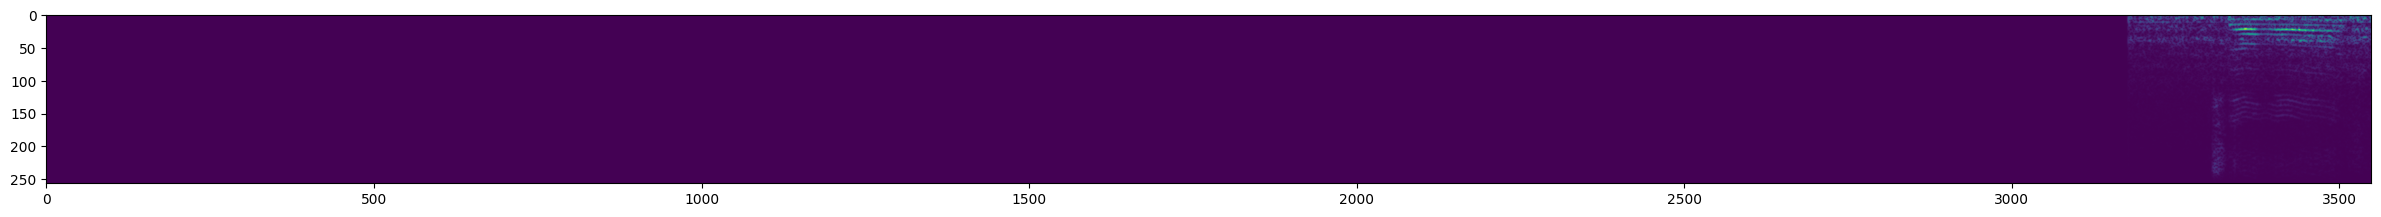

In [22]:
plt.figure(figsize=(30, 10))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.config.optimizer.set_jit(True)

train = data_path.map(lambda x: extract_class(x))
train = train.map(preprocess, num_parallel_calls=AUTOTUNE)
train = train.shuffle(buffer_size=500)
train = train.batch(16, num_parallel_calls=AUTOTUNE)
train = train.prefetch(buffer_size=AUTOTUNE)

In [24]:
test = data_path_test.map(lambda x: extract_class(x))
test = test.map(preprocess, num_parallel_calls=AUTOTUNE)
test = test.batch(16, num_parallel_calls=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)

In [25]:
# number_of_train = int(np.ceil(len(dataset) * 0.85))
# train = dataset.take(number_of_train)
# test = dataset.skip(number_of_train)

In [26]:
len(train)

986

In [27]:
len(test)

72

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
print(f"Samples shape: {samples.shape}")
print(f"Labels shape: {labels.shape}")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D

In [ ]:
for batch in train.take(1):
    input_shape = shape = batch[0].shape

In [26]:
from keras.layers import Attention, Concatenate
from keras.models import Model
input_encode = layers.Input(shape=(input_shape[1], input_shape[2], 1))
pool1 = layers.MaxPooling2D((2, 2))(input_encode)
resize = layers.Resizing(300, 100)(pool1)
conv2d_1 = Conv2D(128, (3,3), activation='relu', padding='same')(resize)
batch_norm = layers.BatchNormalization()(conv2d_1)
pool2 = layers.MaxPooling2D((2, 2))(batch_norm)
conv2d_2 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
batch_norm2 = layers.BatchNormalization()(conv2d_2)
pool3 = layers.MaxPooling2D((2, 2))(batch_norm2)

reshape = layers.Reshape(target_shape=(75, -1))(pool3)
dense_1 = layers.Dense(128, activation="relu")(reshape)
dropout1 = layers.Dropout(0.2)(dense_1)
conv1d = layers.Conv1D(64, 3, activation="relu", padding="same")(dropout1)

In [27]:
lstm1 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(conv1d)
lstm2 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(lstm1)

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights



attention = BahdanauAttention(256)
context_vector, attention_weights = attention(lstm2[:, -1, :], lstm2)

context_vector_repeated = tf.keras.layers.RepeatVector(lstm2.shape[1])(context_vector)

combined = tf.keras.layers.Concatenate(axis=-1)([context_vector_repeated, lstm2])

decoder_lstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(combined)

output = layers.GlobalAveragePooling1D()(decoder_lstm)

output = layers.Dense(10, activation='softmax')(output)


model = Model(inputs=input_encode, outputs=output)

In [28]:
model.compile('Adam', loss='CategoricalCrossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3549, 257, 1)]       0         []                            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 1774, 128, 1)         0         ['input_1[0][0]']             
 D)                                                                                               
                                                                                                  
 resizing (Resizing)         (None, 300, 100, 1)          0         ['max_pooling2d[0][0]']       
                                                                                                  
 conv2d (Conv2D)             (None, 300, 100, 128)        1280      ['resizing[0][0]']        

In [30]:
hist = model.fit(train, epochs=11, validation_data=test)

Epoch 1/11


W0000 00:00:1720132196.538042    5860 hlo_rematerialization.cc:2946] Can't reduce memory use below 818.37MiB (858127289 bytes) by rematerialization; only reduced to 956.94MiB (1003420908 bytes), down from 956.94MiB (1003420908 bytes) originally
I0000 00:00:1720132196.805302    5860 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720132199.068669    5861 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


986/986 [==============================] - 331s 303ms/step - loss: 1.3470 - categorical_accuracy: 0.5022 - recall: 0.3263 - precision: 0.6880 - val_loss: 0.9011 - val_categorical_accuracy: 0.6612 - val_recall: 0.5595 - val_precision: 0.7436
Epoch 2/11
985/986 [============================>.] - ETA: 0s - loss: 0.9128 - categorical_accuracy: 0.6722 - recall: 0.5871 - precision: 0.7687

W0000 00:00:1720132829.030594    5855 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


986/986 [==============================] - 352s 355ms/step - loss: 0.9127 - categorical_accuracy: 0.6722 - recall: 0.5871 - precision: 0.7687 - val_loss: 0.7904 - val_categorical_accuracy: 0.7150 - val_recall: 0.6273 - val_precision: 0.7978
Epoch 3/11
986/986 [==============================] - 322s 325ms/step - loss: 0.7055 - categorical_accuracy: 0.7526 - recall: 0.6959 - precision: 0.8245 - val_loss: 1.2930 - val_categorical_accuracy: 0.5621 - val_recall: 0.4857 - val_precision: 0.6367
Epoch 4/11
986/986 [==============================] - 323s 325ms/step - loss: 0.6320 - categorical_accuracy: 0.7786 - recall: 0.7272 - precision: 0.8400 - val_loss: 0.5873 - val_categorical_accuracy: 0.7897 - val_recall: 0.7454 - val_precision: 0.8649
Epoch 5/11
986/986 [==============================] - 323s 325ms/step - loss: 0.5732 - categorical_accuracy: 0.7956 - recall: 0.7547 - precision: 0.8564 - val_loss: 0.6099 - val_categorical_accuracy: 0.7924 - val_recall: 0.7272 - val_precision: 0.8558
Epo

In [31]:
hist.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'recall', 'precision', 'val_loss', 'val_categorical_accuracy', 'val_recall', 'val_precision'])

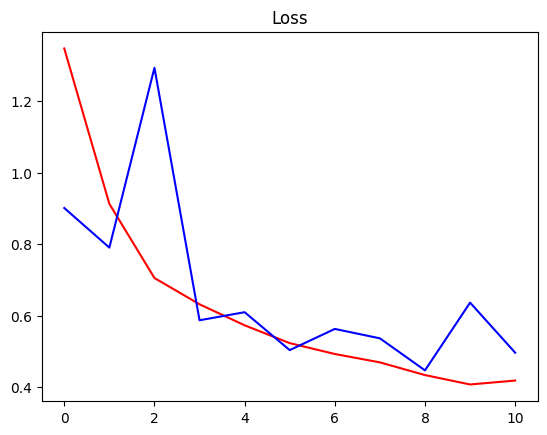

In [32]:
plt.title('Loss')
plt.plot(hist.history[list(hist.history.keys())[0]], 'r')
plt.plot(hist.history[list(hist.history.keys())[4]], 'b')
plt.show()

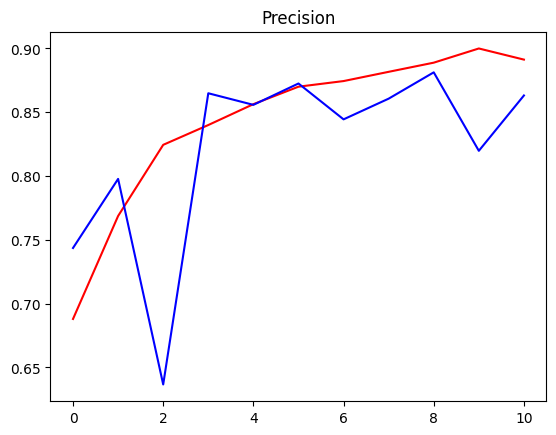

In [33]:
plt.title('Precision')
plt.plot(hist.history[list(hist.history.keys())[3]], 'r')
plt.plot(hist.history[list(hist.history.keys())[7]], 'b')
plt.show()

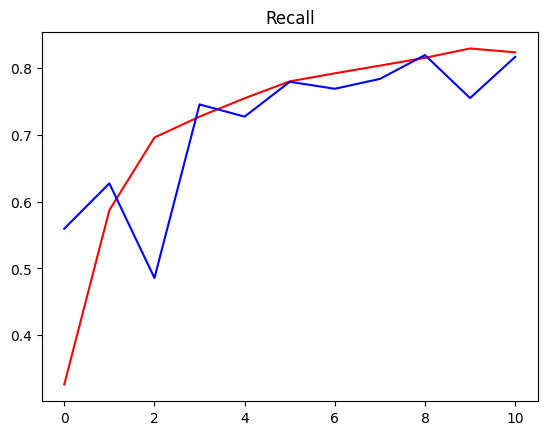

In [34]:
plt.title('Recall')
plt.plot(hist.history[list(hist.history.keys())[2]], 'r')
plt.plot(hist.history[list(hist.history.keys())[6]], 'b')
plt.show()

In [35]:
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [36]:
y_test.argmax(axis=1) == yhat.argmax(axis=1)

array([False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True,  True,  True])

In [37]:
model.evaluate(test)

72/72 [==============================] - 8s 103ms/step - loss: 0.4967 - categorical_accuracy: 0.8349 - recall: 0.8167 - precision: 0.8632


[0.49666836857795715,
 0.8349261283874512,
 0.8166811466217041,
 0.8631772398948669]

In [38]:
from sklearn.metrics import classification_report
report = classification_report(y_test.argmax(axis=1), yhat.argmax(axis=1)) 
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.67      0.80         3
           3       1.00      0.67      0.80         3
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         1
           6       0.50      1.00      0.67         1
           7       0.50      1.00      0.67         2
           8       1.00      1.00      1.00         2

    accuracy                           0.81        16
   macro avg       0.88      0.85      0.82        16
weighted avg       0.91      0.81      0.82        16



In [39]:
from pydub import AudioSegment
def convert_sound(input_file: str, output_file: str, output_format: str):
    audio = AudioSegment.from_file(input_file)
    audio.export(output_file, format=output_format)
    print(f"File converted and saved as {output_file}")
def convert_music_format(input_file, output_file):
    output_format = output_file.split(os.sep)[-1].split('.')[-1]
    convert_sound(input_file, output_file, output_format)

/home/mobo/miniconda3/envs/tf15/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [40]:
import librosa

In [41]:
from pydub import AudioSegment

# def convert_to_wav(input_file, output_file):
#     audio = AudioSegment.from_file(input_file)
#     audio.export(output_file, format="wav")

# input_file = "test1"
# output_file = "outputfile.wav"
# convert_to_wav(input_file, output_file)

In [45]:
model.save('voice_model.tf')

INFO:tensorflow:Assets written to: voice_model.tf/assets


INFO:tensorflow:Assets written to: voice_model.tf/assets


In [109]:
# keras.models.load_model('voice_model.tf')